## Загрузка и обработка данных

In [ ]:
import cv2
import mediapipe as mp
from cvzone.PlotModule import LivePlot
import pandas as pd
import numpy as np
import glob
import os
import openpyxl
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial import distance
import math
from statistics import mean
from math import pi

In [70]:
# группировка landmarks по частям лица
head_circle = [10, 338, 297, 332, 284, 251, 389, 356, 454, 323, 361, 288, 397, 365, 379, 378, 400, 377, 152, 148, 176, 149, 150, 136, 172, 58, 132, 93, 234, 127, 162, 21, 54, 103, 67, 109]

eye_l = [33, 7, 163, 144, 145, 153, 154, 155, 133, 173, 157, 158, 159, 160, 161, 246]
eye_r = [362, 382, 381, 380, 374, 373, 390, 249, 263, 466, 388, 387, 386, 385, 384, 398]

eye_brow_l = [55, 107, 66, 105, 63, 70, 46, 53, 52, 65]
eye_brow_r = [285, 336, 296, 334, 293, 300, 276, 283, 282, 295]

nose_circle = [168, 193, 245, 188, 217, 209, 49, 102, 129, 64, 98, 240, 75, 60, 99, 2, 328, 290, 305, 460, 327, 294, 358, 278, 279, 429, 437, 412, 417, 168]
nose_center_vert = [168, 6, 197, 195, 5, 4, 1, 19, 94, 2]
nose_first_line = [193, 168, 417]
nose_second_line = [114, 188, 122, 6, 351, 412, 343]
nose_third_line = [217, 174, 196, 197, 419, 399, 437]
nose_fouth_line = [209, 198, 236, 3, 195, 248, 456, 420, 429]
nose_fifth_line = [102, 131, 134, 51, 5, 281, 363, 360, 279]
nose_sixth_line = [48, 115, 220, 45, 4, 175, 440, 344, 278]
nose_seventh_line = [429, 64, 98, 240, 75, 60, 99, 2, 328, 290, 305, 460, 327, 294, 358]

mouth_inn = [13, 312, 311, 310, 415, 308, 324, 318, 402, 317, 14, 87, 178, 88, 95, 78, 191, 80, 81, 82]
mouth_out = [0, 267, 269, 270, 409, 291, 375, 375, 321, 405, 314, 17, 84, 181, 106, 146, 61, 185, 40, 39, 37, 37]

In [71]:
# Путь до папки с фотографиями лиц
path_to_big_5_data = ''
# Путь для сохранения csv размеченным и рассчитанными по формулам параметрам лиц
path_to_big_5_csv = ''

### Вычисление точек landmarks для лица на фотогафии

In [72]:
IMAGE_DIR = path_to_big_5_data+'*.png'
NUM_LANDMARKS = 468
RADIUS = 5
COLOR = (100, 100, 0)


# Лучше создавать DataFrame в начале и заполнять его в цикле, чем создавать пустой DataFrame и потом объединять в цикле
coord = pd.DataFrame(index=range(NUM_LANDMARKS))

container_path = []
container_name = []

for img in sorted(glob.glob(IMAGE_DIR)):
    img = img.replace('\\', '/')

    image = cv2.imread(img)

    container_path.append(img)
    name = img.split('/')[-1]
    container_name.append(name)

    mp_face_mesh = mp.solutions.face_mesh
    face_mesh = mp_face_mesh.FaceMesh()
    rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    metrics_im = pd.DataFrame(index=range(NUM_LANDMARKS))

    # Facial landmarks
    result = face_mesh.process(rgb_image)
    height, width, _ = image.shape

    for facial_landmarks in result.multi_face_landmarks:
        for i in range(NUM_LANDMARKS):
            pt1 = facial_landmarks.landmark[i]
            x = int(pt1.x * width)
            y = int(pt1.y * height)
            cv2.circle(image, (x, y), RADIUS, COLOR, -1)
            la = len(name) - 8

            metrics_im.loc[i, name + 'x'] = x
            metrics_im.loc[i, name + 'y'] = y

    coord = pd.concat([coord, metrics_im], axis=1)

    # Если нужно показывать изображение во время обработки
#     cv2.imshow("Image", image)
#     if cv2.waitKey(1) & 0xFF == ord('q'):
#         break

container_path = sorted(container_path)
container_name = sorted(container_name)
coord = coord[sorted(coord.columns)]
display(coord.head())

,10_Agreeableness_enhanced.pngx,10_Agreeableness_enhanced.pngy,10_Agreeableness_reduced.pngx,10_Agreeableness_reduced.pngy,10_Conscientiousness_enhanced.pngx,10_Conscientiousness_enhanced.pngy,10_Conscientiousness_reduced.pngx,10_Conscientiousness_reduced.pngy,10_Extraversion_enhanced.pngx,10_Extraversion_enhanced.pngy,...,9_Extraversion_reduced.pngx,9_Extraversion_reduced.pngy,9_Neuroticism_enhanced.pngx,9_Neuroticism_enhanced.pngy,9_Neuroticism_reduced.pngx,9_Neuroticism_reduced.pngy,9_Openness_enhanced.pngx,9_Openness_enhanced.pngy,9_Openness_reduced.pngx,9_Openness_reduced.pngy
0,178.0,295.0,178.0,297.0,178.0,295.0,178.0,297.0,178.0,297.0,...,179.0,282.0,178.0,280.0,178.0,282.0,178.0,280.0,178.0,283.0
1,178.0,271.0,177.0,272.0,178.0,272.0,178.0,272.0,178.0,273.0,...,179.0,256.0,178.0,255.0,178.0,256.0,178.0,255.0,178.0,256.0
2,178.0,278.0,177.0,280.0,177.0,279.0,177.0,279.0,177.0,280.0,...,178.0,264.0,178.0,263.0,178.0,264.0,177.0,263.0,177.0,264.0
3,171.0,243.0,170.0,244.0,171.0,243.0,170.0,244.0,170.0,244.0,...,172.0,230.0,172.0,231.0,171.0,230.0,172.0,230.0,171.0,230.0
4,178.0,262.0,177.0,264.0,178.0,263.0,177.0,264.0,177.0,264.0,...,179.0,248.0,179.0,248.0,178.0,248.0,178.0,247.0,178.0,248.0


In [73]:
coord.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 468 entries, 0 to 467
Columns: 794 entries, 10_Agreeableness_enhanced.pngx to 9_Openness_reduced.pngy
dtypes: float64(794)
memory usage: 2.8 MB


In [74]:
columns_new = [col[:-1] for col in coord.columns]
# Создание списка для мультииндекса с координатами x и y
x_y = ['x', 'y'] * (len(coord.columns) // 2)
arrays = [columns_new, x_y]
coord.columns = pd.MultiIndex.from_arrays(arrays) 

**Основные функции для нахождения относительных величин в пространстве**

In [75]:
# Основные функции для нахождения относительных величин в пространстве
def datas(frame):
    frame = frame.fillna('')
    return frame.describe().iloc[[1, 3, 5, 7]]

def eucl_dist(first, second):
    return distance.euclidean(first, second)

def point(left: tuple, right: tuple, up: tuple, down: tuple) -> list:
    x1_1, y1_1 = left
    x1_2, y1_2 = right
    x2_1, y2_1 = up
    x2_2, y2_2 = down
    A1 = y1_1 - y1_2
    B1 = x1_2 - x1_1
    C1 = x1_1*y1_2 - x1_2*y1_1
    A2 = y2_1 - y2_2
    B2 = x2_2 - x2_1
    C2 = x2_1*y2_2 - x2_2*y2_1
    intersection = []
    if B1*A2 - B2*A1 and A1:
        y = (C2*A1 - C1*A2) / (B1*A2 - B2*A1)
        x = (-C1 - B1*y) / A1
        intersection.append(x)
        intersection.append(y)
    elif B1*A2 - B2*A1 and A2:
        y = (C2*A1 - C1*A2) / (B1*A2 - B2*A1)
        x = (-C2 - B2*y) / A2
        intersection.append(x)
        intersection.append(y)
    return intersection

def square(points):
    all_lengths = sum(eucl_dist(coords.loc[points[i]].values, coords.loc[points[i+1]].values) for i in range(0, len(points), 2))
    radius = mean(eucl_dist(coords.loc[points[i]].values, coords.loc[points[i+1]].values) for i in range(0, len(points), 2))
    square = pi * radius ** 2
    return square

def angl(first, second, third):
    c = euclidean_distance(first, second)
    a = euclidean_distance(second, third)
    b = euclidean_distance(first, third)

    cos_a = (a**2 + c**2 - b**2) / (2 * a * c)
    cos_b = (a**2 + b**2 - c**2) / (2 * a * b)
    cos_c = (b**2 + c**2 - a**2) / (2 * c * b)

    angle_a = math.degrees(np.arccos(cos_c))
    angle_b = math.degrees(np.arccos(cos_b))
    angle_c = math.degrees(np.arccos(cos_a))

    return angle_a

def max_brow(data, brow, z):
    eye_brow_r_c = [[data.loc[i]['x'], z[1]] for i in brow]
    eye_brow_r_coords = [[data.loc[i]['x'], data.loc[i]['y']] for i in brow]
    br_r = [((coord[0]-z[0])**2 + (coord[1]-z[1])**2)**0.5 for coord in eye_brow_r_coords]
    return brow[br_r.index(max(br_r))]

def max_min_point(p1, p2, z1, z2):
    puu1 = [p1[0], z1[1]]
    puu2 = [p2[0], z2[1]]
    dist_p1_p2 = [eucl_dist(puu1, p1), eucl_dist(puu2, p2)]
    pu_both = [p1, p2]
    return pu_both[dist_p1_p2.index(max(dist_p1_p2))], pu_both[dist_p1_p2.index(min(dist_p1_p2))]

def angle_p(alph, bett, carr):
    c = eucl_dist(np.array(alph), np.array(bett))
    a = eucl_dist(np.array(bett), np.array(carr))
    b = eucl_dist(np.array(alph), np.array(carr))
    cos_a = ((a**2) + (c**2) - (b**2)) / (2*a*c)
    cos_b = ((a**2) + (b**2) - (c**2)) / (2*a*b)
    cos_c = ((b**2) + (c**2) - (a**2)) / (2*c*b)
    pi = np.pi 
    grad3 = np.arccos(cos_a)*180/pi
    return grad3

def br_eye_angl(data, z1, z2, ebr_l, ebr_r, p1, p2):
    max_l_brow                                  = data.loc[max_brow(data, ebr_l, z1)]
    max_r_brow                                  = data.loc[max_brow(data, ebr_r, z2)]
    max_pu, min_pu                              = max_min_point(p1,p2, z1, z2)
    if (max_l_brow[1] - p1[1]) < (max_r_brow[1] - p2[1]):
        npu1 = max_l_brow
        npu2 = max_l_brow[0] + eucl_dist(p1, p2), max_l_brow[1] + (p1[1] - p2[1])
        angl_br_pu                              = angle_p(max_r_brow, max_l_brow, npu2)
    else:
        npu2 = max_r_brow
        npu1 = max_r_brow[0] - eucl_dist(p1, p2), max_r_brow[1] + (p1[1] - p2[1])
        angl_br_pu                              = angle_p(max_l_brow, max_r_brow, npu1)
    return angl_br_pu

def eye_mouth_angl(eye_point1, eye_point2, mouth_center_point1, mouth_center_point2):
    if eye_point1[1] < eye_point2[1]:
        # Если левый глаз расположен выше правого, то используем его координаты для нахождения новых точек.
        new_point1 = eye_point1
        new_point2 = (eye_point1[0] + eucl_dist(mouth_center_point1, mouth_center_point2), 
                      eye_point1[1] - (mouth_center_point1[1] - mouth_center_point2[1]))
        angle = angle_p(eye_point2, new_point1, new_point2)
    else:
        # Если правый глаз расположен выше левого, то используем его координаты для нахождения новых точек.
        new_point2 = eye_point2
        new_point1 = (eye_point2[0] - eucl_dist(mouth_center_point1, mouth_center_point2), 
                      eye_point2[1] - (mouth_center_point1[1] - mouth_center_point2[1]))
        angle = angle_p(eye_point1, new_point2, new_point1)
    return angle


def l_r_ch_mouth(p1, p2, c1, c2):
    if (p1[1] - c1[1]) < (p2[1] - c2[1]):
        pu_ch_l = [p1[0], c1[1]+(abs(p1[0]-c1[0])/eucl_dist(c1, c2))*abs(c1[1] - c2[1])]
        pu_ch_r = [p2[0], c2[1]-(abs(p2[0]-c2[0])/eucl_dist(c2, c1))*abs(c2[1] - c1[1])]
        angl_mo_pu_l                            = angle_p(pu_ch_l, p1, c1)
        angl_mo_pu_r                            = angle_p(pu_ch_r, p2, c2)
    else:
        pu_ch_l = [p1[0], c1[1]-(abs(p1[0]-c1[0])/eucl_dist(c1, c2))*abs(c1[1] - c2[1])]
        pu_ch_r = [p2[0], c2[1]+(abs(p2[0]-c2[0])/eucl_dist(c2, c1))*abs(c2[1] - c1[1])]
        angl_mo_pu_l                            = angle_p(pu_ch_l, p1, c1)
        angl_mo_pu_r                            = angle_p(pu_ch_r, p2, c2)
    return angl_mo_pu_l, angl_mo_pu_r

In [76]:
spisok = [col[0][3:-6] for col in coord.columns[::2]]

In [77]:
spisok_filtered = list(set(spisok))

In [78]:
names_col1 = ['Характеристика_5',
        'размер черепа',
        'размер носа',
        'размер челюсти',
        'размер рта относительно головы',
        'Ширина рта',
        'Ширина носа',
        'толщина губ',
        'Площадь глаз',
        'Угол линии бровей тносительно линии глаз',
        'гол наклона рта относительно глаз',
        'Угол наклона левый зрачек - ch1',
        'Угол наклона левый зрачек - ch2',
        'Ширина лба по точкам лобно-височного',
        'размер лба',
        'размер рта относительно лица',
        'Высота средней',
        'Высота нижней',
        'высоты средней к нижней зоне',
        'Ширина по линии губных комиссур',
        'Высота от надглазничного края до ротовой щели',
        'Высота подбородка',
        'Ширина по линии «волевых желваков»',
        'Высота носогубной области',
        'Ширина спинки носа',
        'Ширина глазной щели',
        'Высота глазной щели/ширина глазной щели',
        'Высота глазной щели/ширина глазной щели2',
        'Тип челюсти',
        'Тип челюсти2',
        'Лобный индекс',
        'Толщина рта/ширина рта',
        'Высота верхней зоны лица'
        ]

indexes = list(range(len(spisok)))

params_face = pd.DataFrame(columns = names_col1)

**Расчет основных параметров лица**

In [79]:
# Вычисление необходимых параметров лица
for i in range(0, len(coord.columns),2):
    coords                                      = pd.DataFrame()
    coords['x']                                 = coord[coord.columns[i]]
    coords['y']                                 = coord[coord.columns[i+1]]
    
    h_lba                                       = (eucl_dist(coords.loc[9].copy().values, coords.loc[152].copy().values)/66)*33
    x_lba, y_lba                                = coords.loc[9].copy().values

    coords.loc[468]                             = [x_lba, (y_lba - h_lba)]

    #coords['y']                                 = coords['y']*(-1)

    zy1                                         = coords.loc[116].copy().values
    zy2                                         = coords.loc[345].copy().values
    na                                          = coords.loc[197].copy().values
    # 1 Ширина скуловых выступов
    zy                                          = eucl_dist(zy1, zy2)
    zi                                          = (eucl_dist(zy1, na)/eucl_dist(na, zy2))*100
    tr                                          = coords.loc[468].copy().values
    # tr = coords.loc[10].copy().values
    gn                                          = coords.loc[152].copy().values
    # 2 Максимальная высота лица
    tr_gn                                       = eucl_dist(tr, gn)
    ft1                                         = coords.loc[53].copy().values
    ft2                                         = coords.loc[283].copy().values
    # 3 Ширина лба по точкам лобно-височного сочленения
    ft                                          = eucl_dist(ft1, ft2)
    ft_i                                        = (ft/ zy)*100
    chc1                                        = coords.loc[172].copy().values
    chc2                                        = coords.loc[397].copy().values
    # 4 Ширина по линии губных комиссур
    wch                                         = eucl_dist(chc1, chc2)
    wch_i                                       = (wch/zy)*100
    suob_sto2_x1, suob_sto2_y1                  = coords.loc[364].copy().values
    suob_sto2_x2, suob_sto2_y2                  = coords.loc[434].copy().values
    suob_sto1                                   = coords.loc[276].copy().values
    suob_sto2                                   = [suob_sto2_x1, suob_sto2_y2]
    # 5 Высота от надглазничного края до ротовой щели
    suob_sto                                    = eucl_dist(suob_sto1, suob_sto2)
    mssto_i                                     = (suob_sto/tr_gn)*100
    sto                                         = coords.loc[14].copy().values
    # 6 Высота подбородка
    sto_gn                                      = eucl_dist(sto, gn)
    sto_gn_i                                    = (sto_gn/eucl_dist(tr,gn*2))*100
    goi                                         = (eucl_dist(chc1, sto)/eucl_dist(sto, chc2))*100
    masseter1                                   = coords.loc[58].copy().values
    masseter2                                   = coords.loc[288].copy().values
    # 7 Ширина по линии «волевых желваков»
    mm                                          = eucl_dist(masseter1, masseter2)
    mm_i                                        = (mm/zy)*100
    ch1                                         = coords.loc[61].copy().values
    ch2                                         = coords.loc[291].copy().values
    # 8 Ширина рта
    ch                                          = eucl_dist(ch1, ch2)
    ch_i                                        = (ch/zy)*100
    chi                                         = eucl_dist(ch1, sto)/eucl_dist(sto, ch2)*100
    suos_tme1_x1, suos_tme1_y1                  = coords.loc[55].copy().values
    suos_tme1_x2, suos_tme1_y2                  = coords.loc[65].copy().values
    suos_tme1                                   = [round((suos_tme1_x1+suos_tme1_x2)/2), round((suos_tme1_y1+suos_tme1_y2)/2)]
    suos_tme2                                   = coords.loc[176].copy().values
    # 9 Высота от надглазничного края до подбородочного бугорка
    suos_tme                                    = eucl_dist(suos_tme1, suos_tme2)
    suob_go1                                    = ft1
    suob_go2                                    = coords.loc[136].copy().values
    # 10 Высота от надглазничного края до угла нижней челюсти
    suob_go                                     = eucl_dist(suob_go1, suob_go2)
    sn                                          = coords.loc[2].copy().values
    # 11 Высота носогубной области
    sn_sto                                      = eucl_dist(sn, sto)
    snsto_i                                     = (sn_sto/tr_gn)*100
    n                                           = coords.loc[168].copy().values
    # 12 Высота носа
    n_sn                                        = eucl_dist(n, sn)
    nsn_i                                       = (n_sn/tr_gn)*100
    al1                                         = coords.loc[129].copy().values
    al2                                         = coords.loc[358].copy().values
    aln                                         = coords.loc[4].copy().values
    # 13 Ширина крыльев носа
    al                                          = eucl_dist(al1, al2)
    wans                                        = (al/zy)*100
    ali                                         = (eucl_dist(al1, aln)/eucl_dist(aln, al2))*100
    ls                                          = coords.loc[0].copy().values
    li                                          = coords.loc[17].copy().values
    # 14 Максимальная толщина губ
    ls_li                                       = eucl_dist(ls, li)
    lsli_i                                      = (ls_li/tr_gn)*100
    sna1                                        = coords.loc[196].copy().values
    sna2                                        = coords.loc[419].copy().values
    # 15 Ширина спинки носа
    sp                                          = square(head_circle)
    sna                                         = eucl_dist(sna1, sna2)
    ni1                                         = n_sn/al
    ni2                                         = sna/al
    snr                                         = (sna+(al*n_sn))/(2*sp)
    wna_i                                       = (sna/zy)*100
    es                                          = coords.loc[33].copy().values
    en1                                         = coords.loc[133].copy().values
    en2                                         = coords.loc[362].copy().values
    ez1                                         = coords.loc[33].copy().values
    ez2                                         = coords.loc[263].copy().values
    # 16 Ширина глазной щели
    en_es                                       = eucl_dist(en1, es)
    en_es_i                                     = (en_es/zy)*100
    eni                                         = (eucl_dist(en1, n)/eucl_dist(en2, n))*100
    ezi                                         = (eucl_dist(ez1, n)/eucl_dist(ez2, n))*100
    suos_tme1_x1, suos_tme1_y1                  = coords.loc[158].copy().values
    suos_tme1_x2, suos_tme1_y2                  = coords.loc[159].copy().values
    sc                                          = [round((suos_tme1_x1+suos_tme1_x2)/2), round((suos_tme1_y1+suos_tme1_y2)/2)]
    ic                                          = coords.loc[145].copy().values
    pu1                                         = point(coords.loc[33].copy().values, coords.loc[133].copy().values, coords.loc[159].copy().values, coords.loc[145].copy().values)
    pu2                                         = point(coords.loc[362].copy().values, coords.loc[263].copy().values, coords.loc[386].copy().values, coords.loc[374].copy().values)
    # Угол линии бровей тносительно линии глаз
    # Выступающие координаты бровей и какие из них больше и меньше, также определяем глаза
    angl_br_pu                                  = br_eye_angl(coords, zy1, zy2, eye_brow_l, eye_brow_r, pu1, pu2)
    # Угол линии глаз относительно линии рта
    # Угол наклона рта относительно глаз
    angl_mo_pu                                  = eye_mouth_angl(pu1, pu2, ch1, ch2)
    # Угол наклона левый зрачек - ch1 и перппендикурялом вниз от зрачка до уровня рта
    # Угол наклона правый зрачек - ch2 и перппендикурялом вниз от зрачка до уровня рта
    angl_mo_pu_l, angl_mo_pu_r                  = l_r_ch_mouth(pu1, pu2, ch1, ch2)
    # 17 Высота глазной щели
    sc_ic                                       = eucl_dist(sc, ic)
    # Высота глазной щели/ширина глазной щели
    oi                                          = (sc_ic)/(en_es)
    scic_i                                      = (sc_ic/tr_gn)*100
    # Относительная площадь зоны рта
    slar                                        = (ls_li)*(ch/sp)
    # Относительная  площадь глазной щели
    sor                                         = (sc_ic)*(en_es)/sp
    pui                                         = (eucl_dist(pu1, n)/eucl_dist(pu2, n))*100
    # Тип челюсти
    mg                                          = suob_go/suos_tme
    sh_ex                                       = ch/eucl_dist(ez1, ez2)*100
    # Индекс носового выступа
    prn                                         = coords.loc[1].copy().values
    nvi                                         = eucl_dist(sn, prn)/eucl_dist(n, prn)
    # Челюстной индекс по вертикали
    mi                                          = eucl_dist(sn, gn)/n_sn
    # Лобный индекс по вертикали
    fri                                         = eucl_dist(tr, n)/n_sn
    # Толщина рта/ширина рта
    la                                          = ls_li/ch
    # Высота верхней зоны лица
    suph                                        = (eucl_dist(tr, n)/tr_gn)*100
    # Высота средней зоны лица
    medh                                        = (eucl_dist(n,sn)/tr_gn)*100
    # Высота нижней зоны лица
    infh                                        = (eucl_dist(sn, gn)/tr_gn)*100
    # Отношение высоты средней к нижней зоне
    med_inf                                     = eucl_dist(n, sn)/eucl_dist(sn, gn)*100
    # Высота лба
    tr_n                                        = eucl_dist(tr, n)
    # Площадь глаз относительно лица
    sq_eye_l                                    = square(eye_l)
    sq_eye_r                                    = square(eye_r)
    sq_head                                     = square(head_circle)
    eye_head                                    = (sq_eye_l+sq_eye_r)/sq_head
    sq_nose                                     = square(nose_circle)
    sq_nose                                     = square(nose_circle)
    nose_head                                   = sq_nose/sq_head
    sq_mouth                                    = square(mouth_out)
    mouth_head                                  = sq_mouth/sq_head
    # размер черепа
    par_ch = tr_gn/zy*100
    # размер лба относительно лица
    lob_ch = eucl_dist(coords.loc[8].copy().values, coords.loc[468].copy().values)/tr_gn*100
    # размер рта относительно лица
    eybr_ch = ((eucl_dist(coords.loc[52].copy().values, coords.loc[159].copy().values)+eucl_dist(coords.loc[282].copy().values, coords.loc[386].copy().values))/2)/tr_gn*100
   
    third = [coord.columns[i][0][:len(coord.columns[i])-6], 
             par_ch, nsn_i, mi, mouth_head, ch_i,
         wans, lsli_i, eye_head, angl_br_pu, angl_mo_pu,
         angl_mo_pu_l, angl_mo_pu_r, ft_i, lob_ch,eybr_ch, 
         medh, infh, med_inf, wch_i, mssto_i, 
         sto_gn_i, mm_i, snsto_i, wna_i, en_es_i,
         oi, scic_i, mg, sh_ex, fri,
         la, suph]
    
    params_face.loc[len(params_face)]           = third


    
    
params_face = params_face.fillna(0)

C:\Users\taras\AppData\Local\Temp\ipykernel_13892\1053405856.py:83: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if (max_l_brow[1] - p1[1]) < (max_r_brow[1] - p2[1]):
C:\Users\taras\AppData\Local\Temp\ipykernel_13892\1053405856.py:89: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  npu1 = max_r_brow[0] - eucl_dist(p1, p2), max_r_brow[1] + (p1[1] - p2[1])
C:\Users\taras\AppData\Local\Temp\ipykernel_13892\1053405856.py:83: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value b

C:\Users\taras\AppData\Local\Temp\ipykernel_13892\1053405856.py:83: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if (max_l_brow[1] - p1[1]) < (max_r_brow[1] - p2[1]):
C:\Users\taras\AppData\Local\Temp\ipykernel_13892\1053405856.py:85: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  npu2 = max_l_brow[0] + eucl_dist(p1, p2), max_l_brow[1] + (p1[1] - p2[1])
C:\Users\taras\AppData\Local\Temp\ipykernel_13892\1053405856.py:83: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value b

C:\Users\taras\AppData\Local\Temp\ipykernel_13892\1053405856.py:83: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if (max_l_brow[1] - p1[1]) < (max_r_brow[1] - p2[1]):
C:\Users\taras\AppData\Local\Temp\ipykernel_13892\1053405856.py:85: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  npu2 = max_l_brow[0] + eucl_dist(p1, p2), max_l_brow[1] + (p1[1] - p2[1])
C:\Users\taras\AppData\Local\Temp\ipykernel_13892\1053405856.py:83: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value b

C:\Users\taras\AppData\Local\Temp\ipykernel_13892\1053405856.py:83: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if (max_l_brow[1] - p1[1]) < (max_r_brow[1] - p2[1]):
C:\Users\taras\AppData\Local\Temp\ipykernel_13892\1053405856.py:85: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  npu2 = max_l_brow[0] + eucl_dist(p1, p2), max_l_brow[1] + (p1[1] - p2[1])
C:\Users\taras\AppData\Local\Temp\ipykernel_13892\1053405856.py:83: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value b

C:\Users\taras\AppData\Local\Temp\ipykernel_13892\1053405856.py:83: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if (max_l_brow[1] - p1[1]) < (max_r_brow[1] - p2[1]):
C:\Users\taras\AppData\Local\Temp\ipykernel_13892\1053405856.py:85: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  npu2 = max_l_brow[0] + eucl_dist(p1, p2), max_l_brow[1] + (p1[1] - p2[1])
C:\Users\taras\AppData\Local\Temp\ipykernel_13892\1053405856.py:83: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value b

C:\Users\taras\AppData\Local\Temp\ipykernel_13892\1053405856.py:83: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if (max_l_brow[1] - p1[1]) < (max_r_brow[1] - p2[1]):
C:\Users\taras\AppData\Local\Temp\ipykernel_13892\1053405856.py:85: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  npu2 = max_l_brow[0] + eucl_dist(p1, p2), max_l_brow[1] + (p1[1] - p2[1])
C:\Users\taras\AppData\Local\Temp\ipykernel_13892\1053405856.py:83: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value b

C:\Users\taras\AppData\Local\Temp\ipykernel_13892\1053405856.py:83: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if (max_l_brow[1] - p1[1]) < (max_r_brow[1] - p2[1]):
C:\Users\taras\AppData\Local\Temp\ipykernel_13892\1053405856.py:89: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  npu1 = max_r_brow[0] - eucl_dist(p1, p2), max_r_brow[1] + (p1[1] - p2[1])
C:\Users\taras\AppData\Local\Temp\ipykernel_13892\1053405856.py:83: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value b

C:\Users\taras\AppData\Local\Temp\ipykernel_13892\1053405856.py:83: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if (max_l_brow[1] - p1[1]) < (max_r_brow[1] - p2[1]):
C:\Users\taras\AppData\Local\Temp\ipykernel_13892\1053405856.py:85: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  npu2 = max_l_brow[0] + eucl_dist(p1, p2), max_l_brow[1] + (p1[1] - p2[1])
C:\Users\taras\AppData\Local\Temp\ipykernel_13892\1053405856.py:83: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value b

C:\Users\taras\AppData\Local\Temp\ipykernel_13892\1053405856.py:83: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if (max_l_brow[1] - p1[1]) < (max_r_brow[1] - p2[1]):
C:\Users\taras\AppData\Local\Temp\ipykernel_13892\1053405856.py:85: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  npu2 = max_l_brow[0] + eucl_dist(p1, p2), max_l_brow[1] + (p1[1] - p2[1])
C:\Users\taras\AppData\Local\Temp\ipykernel_13892\1053405856.py:83: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value b

C:\Users\taras\AppData\Local\Temp\ipykernel_13892\1053405856.py:83: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if (max_l_brow[1] - p1[1]) < (max_r_brow[1] - p2[1]):
C:\Users\taras\AppData\Local\Temp\ipykernel_13892\1053405856.py:85: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  npu2 = max_l_brow[0] + eucl_dist(p1, p2), max_l_brow[1] + (p1[1] - p2[1])
C:\Users\taras\AppData\Local\Temp\ipykernel_13892\1053405856.py:83: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value b

C:\Users\taras\AppData\Local\Temp\ipykernel_13892\1053405856.py:83: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if (max_l_brow[1] - p1[1]) < (max_r_brow[1] - p2[1]):
C:\Users\taras\AppData\Local\Temp\ipykernel_13892\1053405856.py:85: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  npu2 = max_l_brow[0] + eucl_dist(p1, p2), max_l_brow[1] + (p1[1] - p2[1])
C:\Users\taras\AppData\Local\Temp\ipykernel_13892\1053405856.py:83: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value b

C:\Users\taras\AppData\Local\Temp\ipykernel_13892\1053405856.py:83: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if (max_l_brow[1] - p1[1]) < (max_r_brow[1] - p2[1]):
C:\Users\taras\AppData\Local\Temp\ipykernel_13892\1053405856.py:89: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  npu1 = max_r_brow[0] - eucl_dist(p1, p2), max_r_brow[1] + (p1[1] - p2[1])
C:\Users\taras\AppData\Local\Temp\ipykernel_13892\1053405856.py:83: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value b

C:\Users\taras\AppData\Local\Temp\ipykernel_13892\1053405856.py:83: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if (max_l_brow[1] - p1[1]) < (max_r_brow[1] - p2[1]):
C:\Users\taras\AppData\Local\Temp\ipykernel_13892\1053405856.py:85: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  npu2 = max_l_brow[0] + eucl_dist(p1, p2), max_l_brow[1] + (p1[1] - p2[1])
C:\Users\taras\AppData\Local\Temp\ipykernel_13892\1053405856.py:83: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value b

C:\Users\taras\AppData\Local\Temp\ipykernel_13892\1053405856.py:83: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if (max_l_brow[1] - p1[1]) < (max_r_brow[1] - p2[1]):
C:\Users\taras\AppData\Local\Temp\ipykernel_13892\1053405856.py:85: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  npu2 = max_l_brow[0] + eucl_dist(p1, p2), max_l_brow[1] + (p1[1] - p2[1])
C:\Users\taras\AppData\Local\Temp\ipykernel_13892\1053405856.py:83: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value b

C:\Users\taras\AppData\Local\Temp\ipykernel_13892\1053405856.py:83: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if (max_l_brow[1] - p1[1]) < (max_r_brow[1] - p2[1]):
C:\Users\taras\AppData\Local\Temp\ipykernel_13892\1053405856.py:85: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  npu2 = max_l_brow[0] + eucl_dist(p1, p2), max_l_brow[1] + (p1[1] - p2[1])
C:\Users\taras\AppData\Local\Temp\ipykernel_13892\1053405856.py:83: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value b

C:\Users\taras\AppData\Local\Temp\ipykernel_13892\1053405856.py:83: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if (max_l_brow[1] - p1[1]) < (max_r_brow[1] - p2[1]):
C:\Users\taras\AppData\Local\Temp\ipykernel_13892\1053405856.py:89: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  npu1 = max_r_brow[0] - eucl_dist(p1, p2), max_r_brow[1] + (p1[1] - p2[1])
C:\Users\taras\AppData\Local\Temp\ipykernel_13892\1053405856.py:83: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value b

C:\Users\taras\AppData\Local\Temp\ipykernel_13892\1053405856.py:83: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if (max_l_brow[1] - p1[1]) < (max_r_brow[1] - p2[1]):
C:\Users\taras\AppData\Local\Temp\ipykernel_13892\1053405856.py:85: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  npu2 = max_l_brow[0] + eucl_dist(p1, p2), max_l_brow[1] + (p1[1] - p2[1])
C:\Users\taras\AppData\Local\Temp\ipykernel_13892\1053405856.py:83: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value b

C:\Users\taras\AppData\Local\Temp\ipykernel_13892\1053405856.py:83: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if (max_l_brow[1] - p1[1]) < (max_r_brow[1] - p2[1]):
C:\Users\taras\AppData\Local\Temp\ipykernel_13892\1053405856.py:85: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  npu2 = max_l_brow[0] + eucl_dist(p1, p2), max_l_brow[1] + (p1[1] - p2[1])
C:\Users\taras\AppData\Local\Temp\ipykernel_13892\1053405856.py:83: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value b

C:\Users\taras\AppData\Local\Temp\ipykernel_13892\1053405856.py:83: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if (max_l_brow[1] - p1[1]) < (max_r_brow[1] - p2[1]):
C:\Users\taras\AppData\Local\Temp\ipykernel_13892\1053405856.py:85: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  npu2 = max_l_brow[0] + eucl_dist(p1, p2), max_l_brow[1] + (p1[1] - p2[1])
C:\Users\taras\AppData\Local\Temp\ipykernel_13892\1053405856.py:83: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value b

C:\Users\taras\AppData\Local\Temp\ipykernel_13892\1053405856.py:83: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if (max_l_brow[1] - p1[1]) < (max_r_brow[1] - p2[1]):
C:\Users\taras\AppData\Local\Temp\ipykernel_13892\1053405856.py:85: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  npu2 = max_l_brow[0] + eucl_dist(p1, p2), max_l_brow[1] + (p1[1] - p2[1])
C:\Users\taras\AppData\Local\Temp\ipykernel_13892\1053405856.py:83: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value b

C:\Users\taras\AppData\Local\Temp\ipykernel_13892\1053405856.py:83: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if (max_l_brow[1] - p1[1]) < (max_r_brow[1] - p2[1]):
C:\Users\taras\AppData\Local\Temp\ipykernel_13892\1053405856.py:89: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  npu1 = max_r_brow[0] - eucl_dist(p1, p2), max_r_brow[1] + (p1[1] - p2[1])
C:\Users\taras\AppData\Local\Temp\ipykernel_13892\1053405856.py:83: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value b

C:\Users\taras\AppData\Local\Temp\ipykernel_13892\1053405856.py:83: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if (max_l_brow[1] - p1[1]) < (max_r_brow[1] - p2[1]):
C:\Users\taras\AppData\Local\Temp\ipykernel_13892\1053405856.py:85: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  npu2 = max_l_brow[0] + eucl_dist(p1, p2), max_l_brow[1] + (p1[1] - p2[1])
C:\Users\taras\AppData\Local\Temp\ipykernel_13892\1053405856.py:83: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value b

C:\Users\taras\AppData\Local\Temp\ipykernel_13892\1053405856.py:83: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if (max_l_brow[1] - p1[1]) < (max_r_brow[1] - p2[1]):
C:\Users\taras\AppData\Local\Temp\ipykernel_13892\1053405856.py:85: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  npu2 = max_l_brow[0] + eucl_dist(p1, p2), max_l_brow[1] + (p1[1] - p2[1])
C:\Users\taras\AppData\Local\Temp\ipykernel_13892\1053405856.py:83: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value b

C:\Users\taras\AppData\Local\Temp\ipykernel_13892\1053405856.py:83: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if (max_l_brow[1] - p1[1]) < (max_r_brow[1] - p2[1]):
C:\Users\taras\AppData\Local\Temp\ipykernel_13892\1053405856.py:89: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  npu1 = max_r_brow[0] - eucl_dist(p1, p2), max_r_brow[1] + (p1[1] - p2[1])
C:\Users\taras\AppData\Local\Temp\ipykernel_13892\1053405856.py:83: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value b

C:\Users\taras\AppData\Local\Temp\ipykernel_13892\1053405856.py:83: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if (max_l_brow[1] - p1[1]) < (max_r_brow[1] - p2[1]):
C:\Users\taras\AppData\Local\Temp\ipykernel_13892\1053405856.py:85: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  npu2 = max_l_brow[0] + eucl_dist(p1, p2), max_l_brow[1] + (p1[1] - p2[1])
C:\Users\taras\AppData\Local\Temp\ipykernel_13892\1053405856.py:83: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value b

C:\Users\taras\AppData\Local\Temp\ipykernel_13892\1053405856.py:83: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if (max_l_brow[1] - p1[1]) < (max_r_brow[1] - p2[1]):
C:\Users\taras\AppData\Local\Temp\ipykernel_13892\1053405856.py:89: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  npu1 = max_r_brow[0] - eucl_dist(p1, p2), max_r_brow[1] + (p1[1] - p2[1])
C:\Users\taras\AppData\Local\Temp\ipykernel_13892\1053405856.py:83: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value b

C:\Users\taras\AppData\Local\Temp\ipykernel_13892\1053405856.py:83: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if (max_l_brow[1] - p1[1]) < (max_r_brow[1] - p2[1]):
C:\Users\taras\AppData\Local\Temp\ipykernel_13892\1053405856.py:85: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  npu2 = max_l_brow[0] + eucl_dist(p1, p2), max_l_brow[1] + (p1[1] - p2[1])
C:\Users\taras\AppData\Local\Temp\ipykernel_13892\1053405856.py:83: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value b

C:\Users\taras\AppData\Local\Temp\ipykernel_13892\1053405856.py:83: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if (max_l_brow[1] - p1[1]) < (max_r_brow[1] - p2[1]):
C:\Users\taras\AppData\Local\Temp\ipykernel_13892\1053405856.py:85: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  npu2 = max_l_brow[0] + eucl_dist(p1, p2), max_l_brow[1] + (p1[1] - p2[1])
C:\Users\taras\AppData\Local\Temp\ipykernel_13892\1053405856.py:83: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value b

In [80]:
# Фильтрация и разбиение на датасеты
agreeableness_enhanced = params_face[params_face['Характеристика_5'].str.contains('Agreeableness_enhanced', na=False)]
agreeableness_reduced = params_face[params_face['Характеристика_5'].str.contains('Agreeableness_reduced', na=False)]
conscientiousness_enhanced = params_face[params_face['Характеристика_5'].str.contains('Conscientiousness_enhanced', na=False)]
conscientiousness_reduced = params_face[params_face['Характеристика_5'].str.contains('Conscientiousness_reduced', na=False)]
extraversion_enhanced = params_face[params_face['Характеристика_5'].str.contains('Extraversion_enhanced', na=False)]
extraversion_reduced = params_face[params_face['Характеристика_5'].str.contains('Extraversion_reduced', na=False)]
neuroticism_enhanced = params_face[params_face['Характеристика_5'].str.contains('Neuroticism_enhanced', na=False)]
neuroticism_reduced = params_face[params_face['Характеристика_5'].str.contains('Neuroticism_reduced', na=False)]
openness_enhanced = params_face[params_face['Характеристика_5'].str.contains('Openness_enhanced', na=False)]
openness_reduced = params_face[params_face['Характеристика_5'].str.contains('Openness_reduced', na=False)]

In [81]:
agreeableness_enhanced = agreeableness_enhanced.reset_index(drop = True)
agreeableness_reduced = agreeableness_reduced.reset_index(drop = True)
conscientiousness_enhanced = conscientiousness_enhanced.reset_index(drop = True)
conscientiousness_reduced = conscientiousness_reduced.reset_index(drop = True)
extraversion_enhanced = extraversion_enhanced.reset_index(drop = True)
extraversion_reduced = extraversion_reduced.reset_index(drop = True)
neuroticism_enhanced = neuroticism_enhanced.reset_index(drop = True)
neuroticism_reduced = neuroticism_reduced.reset_index(drop = True)
openness_enhanced = openness_enhanced.reset_index(drop = True)
openness_reduced = openness_reduced.reset_index(drop = True)

In [82]:
# Присвоение метки класса
agreeableness_enhanced['Характеристика_5']='Agreeableness_enhanced'
agreeableness_reduced['Характеристика_5']='Agreeableness_reduced'
conscientiousness_enhanced['Характеристика_5']='Conscientiousness_enhanced'
conscientiousness_reduced['Характеристика_5']='Conscientiousness_reduced'
extraversion_enhanced['Характеристика_5']='Extraversion_enhanced'
extraversion_reduced['Характеристика_5']='Extraversion_reduced'
neuroticism_enhanced['Характеристика_5']='Neuroticism_enhanced'
neuroticism_reduced['Характеристика_5']='Neuroticism_reduced'
openness_enhanced['Характеристика_5']='Openness_enhanced'
openness_reduced['Характеристика_5']='Openness_reduced'

In [83]:
combined_dataset = pd.concat([agreeableness_enhanced, agreeableness_reduced, conscientiousness_enhanced, conscientiousness_reduced, extraversion_enhanced, extraversion_reduced, neuroticism_enhanced, neuroticism_reduced, openness_enhanced, openness_reduced], ignore_index=True)

## Обучение моделей

**Применение CatBoost**

In [16]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.utils import class_weight
from sklearn.utils.class_weight import compute_class_weight

In [17]:
X = combined_dataset.drop("Характеристика_5", axis=1)
y = combined_dataset["Характеристика_5"]

# Стандартизация данных перед применением PCA
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Применение PCA
pca = PCA(n_components=0.95)  # Оставляем 95% дисперсии
X_pca = pca.fit_transform(X_scaled)

# Разделение данных
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=42, stratify=y)

In [18]:
# Рассчитываем веса классов
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights_dict = {label: weight for label, weight in zip(np.unique(y_train), class_weights)}

# Инициализация модели
model = CatBoostClassifier()

# Параметры для GridSearchCV
params = {
    'depth': [3, 5, 7, 9],
    'learning_rate': [0.001, 0.01, 0.05, 0.1],
    'l2_leaf_reg': [1, 3, 5, 7],
    'iterations': [100, 500, 1000]
}

In [19]:
# GridSearchCV
grid_search = GridSearchCV(model, params, cv=5, scoring='accuracy', verbose=1, n_jobs=-1)
grid_search.fit(X_train, y_train, verbose=0)

Fitting 5 folds for each of 192 candidates, totalling 960 fits


GridSearchCV(cv=5,
             estimator=<catboost.core.CatBoostClassifier object at 0x00000215552E9F90>,
             n_jobs=-1,
             param_grid={'depth': [3, 5, 7, 9], 'iterations': [100, 500, 1000],
                         'l2_leaf_reg': [1, 3, 5, 7],
                         'learning_rate': [0.001, 0.01, 0.05, 0.1]},
             scoring='accuracy', verbose=1)

In [20]:
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best cross-validation score: {grid_search.best_score_:.4f}")


Best parameters: {'depth': 3, 'iterations': 500, 'l2_leaf_reg': 1, 'learning_rate': 0.001}
Best cross-validation score: 0.1769


In [21]:
# Проверка качества модели на тестовом наборе данных
best_model = grid_search.best_estimator_
predictions = best_model.predict(X_test)
test_accuracy = accuracy_score(y_test, predictions)

print(f"Accuracy on test set: {test_accuracy:.4f}")

Accuracy on test set: 0.1750


In [30]:
from sklearn.metrics import confusion_matrix, classification_report

# Построение отчета о классификации
class_report = classification_report(y_test, predictions)
print("\nClassification Report:")
print(class_report)



Classification Report:
                            precision    recall  f1-score   support

    Agreeableness_enhanced       0.13      0.25      0.17         8
     Agreeableness_reduced       0.17      0.12      0.14         8
Conscientiousness_enhanced       0.14      0.12      0.13         8
 Conscientiousness_reduced       0.00      0.00      0.00         8
     Extraversion_enhanced       0.31      0.62      0.42         8
      Extraversion_reduced       0.22      0.25      0.24         8
      Neuroticism_enhanced       0.33      0.25      0.29         8
       Neuroticism_reduced       0.00      0.00      0.00         8
         Openness_enhanced       0.00      0.00      0.00         8
          Openness_reduced       0.08      0.12      0.10         8

                  accuracy                           0.17        80
                 macro avg       0.14      0.17      0.15        80
              weighted avg       0.14      0.17      0.15        80



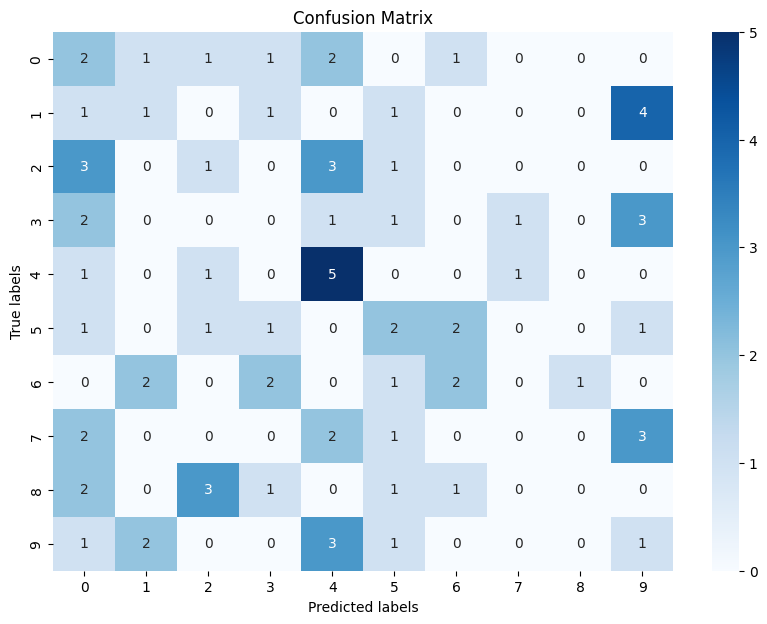

In [29]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10,7))
sns.heatmap(conf_mat, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()


In [84]:
doles = names_col1[1:]

In [85]:

variables = [
    'agreeableness_enhanced',
    'agreeableness_reduced',
    'conscientiousness_enhanced',
    'conscientiousness_reduced',
    'extraversion_enhanced',
    'extraversion_reduced',
    'neuroticism_enhanced',
    'neuroticism_reduced',
    'openness_enhanced',
    'openness_reduced',
]

frames = {var_name: datas(eval(var_name)[doles]) for var_name in variables}
centers = np.concatenate([frame.to_numpy().reshape(1, -1) for frame in frames.values()], axis=0)

In [86]:
# Сохраним средние значения выборки
path_to_big_5_centers = ''

In [87]:
centers = pd.DataFrame(data=centers, columns=doles)
centers['Характеристика_5'] = variables

ValueError: Shape of passed values is (10, 128), indices imply (10, 32)

In [ ]:
centers.to_csv(path_to_big_5_centers+'centers.csv', index= False, sep='\t')

# Загрузка тестируемой фотографии и вычисление параметров лица

In [ ]:
import cv2
import mediapipe as mp
import glob
from cvzone.PlotModule import LivePlot
import openpyxl
from statistics import mean
from math import pi
import pandas as pd
import os
import numpy as np
import openpyxl
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial import distance
import math
from math import sqrt, acos, degrees
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from scipy.spatial import distance
from functools import reduce

import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning) 

In [ ]:
head_circle       = [10, 338, 297, 332, 284, 251, 389, 356, 454, 323, 361, 288, 397, 365, 379, 378, 400, 377, 152, 148, 176, 149, 150, 136, 172, 58, 132, 93, 234, 127, 162, 21, 54, 103, 67, 109]

eye_l             = [33, 7, 163, 144, 145, 153, 154, 155, 133, 173, 157, 158, 159, 160, 161, 246]
eye_r             = [362, 382, 381, 380, 374, 373, 390, 249, 263, 466, 388, 387, 386, 385, 384, 398]

eye_brow_l        = [55, 107, 66, 105, 63, 70, 46, 53, 52, 65]
eye_brow_r        = [285, 336, 296, 334, 293, 300, 276, 283, 282, 295]

nose_circle       = [168, 193, 245, 188, 217, 209, 49, 102, 129, 64, 98, 240, 75, 60, 99, 2, 328, 290, 305, 460, 327, 294, 358, 278, 279, 429, 437, 412, 417, 168]
nose_center_vert  = [168, 6, 197, 195, 5, 4, 1, 19, 94, 2]
nose_first_line   = [193, 168, 417]
nose_second_line  = [114, 188, 122, 6, 351, 412, 343]
nose_third_line   = [217, 174, 196, 197, 419, 399, 437]
nose_fouth_line   = [209, 198, 236, 3, 195, 248, 456, 420, 429]
nose_fifth_line   = [102, 131, 134, 51, 5, 281, 363, 360, 279]
nose_sixth_line   = [48, 115, 220, 45, 4, 175, 440, 344, 278]
nose_seventh_line = [429, 64, 98, 240, 75, 60, 99, 2, 328, 290, 305, 460, 327, 294, 358]

mouth_inn         = [13, 312, 311, 310, 415, 308, 324, 318, 402, 317, 14, 87, 178, 88, 95, 78, 191, 80, 81, 82]
mouth_out         = [0, 267, 269, 270, 409, 291, 375, 375, 321, 405, 314, 17, 84, 181, 106, 146, 61, 185, 40, 39, 37, 37]

In [ ]:
path_to_solo_photo = ''
path_to_big_5_centers = ''
centers = pd.read_csv(path_to_big_5_centers+'centers.csv', sep='\t')

In [ ]:
IMAGE_DIR = path_to_solo_photo+'*.jpg'
NUM_LANDMARKS = 468
RADIUS = 5
COLOR = (100, 100, 0)
# Лучше создавать DataFrame в начале и заполнять его в цикле, чем создавать пустой DataFrame и потом объединять в цикле
coords = pd.DataFrame(index=range(NUM_LANDMARKS))

container_path = []
container_name = []



# coords = pd.DataFrame(index = range(0,468))


for img in sorted(glob.glob(IMAGE_DIR)):
    img = img.replace('\\', '/')
    
    image = cv2.imread(img)
    name = img.split('/')[-1]
    
    mp_face_mesh = mp.solutions.face_mesh
    face_mesh = mp_face_mesh.FaceMesh()
    rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    metrics_im = pd.DataFrame(index=range(NUM_LANDMARKS))
    
    # Facial landmarks
    result = face_mesh.process(rgb_image)
    height, width, _ = image.shape
    
    for facial_landmarks in result.multi_face_landmarks:
        for i in range(NUM_LANDMARKS):
            pt1 = facial_landmarks.landmark[i]
            x = int(pt1.x * width)
            y = int(pt1.y * height)
            cv2.circle(image, (x, y), RADIUS, COLOR, -1)
            la = len(name) - 8

            metrics_im.loc[i, name + 'x'] = x
            metrics_im.loc[i, name + 'y'] = y

    coords = pd.concat([coords, metrics_im], axis=1)

    # Если нужно показывать изображение во время обработки, лучше добавить опцию с клавишей для выхода из цикла (например, "q")
#     cv2.imshow("Image", image)
#     if cv2.waitKey(1) & 0xFF == ord('q'):
#         break


coords = coords[sorted(coords.columns)]
display(coords.head())

***Часть следующего кода дублирует предыдущий***

**Основные функции для нахождения относительных величин в пространстве**

In [ ]:
def eucl_dist(first, second):
    return distance.euclidean(first, second)

def point(left: tuple, right: tuple, up: tuple, down: tuple) -> list:
    x1_1, y1_1 = left
    x1_2, y1_2 = right
    x2_1, y2_1 = up
    x2_2, y2_2 = down
    A1 = y1_1 - y1_2
    B1 = x1_2 - x1_1
    C1 = x1_1*y1_2 - x1_2*y1_1
    A2 = y2_1 - y2_2
    B2 = x2_2 - x2_1
    C2 = x2_1*y2_2 - x2_2*y2_1
    intersection = []
    if B1*A2 - B2*A1 and A1:
        y = (C2*A1 - C1*A2) / (B1*A2 - B2*A1)
        x = (-C1 - B1*y) / A1
        intersection.append(x)
        intersection.append(y)
    elif B1*A2 - B2*A1 and A2:
        y = (C2*A1 - C1*A2) / (B1*A2 - B2*A1)
        x = (-C2 - B2*y) / A2
        intersection.append(x)
        intersection.append(y)
    return intersection

def square(points):
    all_lengths = sum(eucl_dist(coords.loc[points[i]].values, coords.loc[points[i+1]].values) for i in range(0, len(points), 2))
    radius = mean(eucl_dist(coords.loc[points[i]].values, coords.loc[points[i+1]].values) for i in range(0, len(points), 2))
    square = pi * radius ** 2
    return square

def angl(first, second, third):
    c = euclidean_distance(first, second)
    a = euclidean_distance(second, third)
    b = euclidean_distance(first, third)

    cos_a = (a**2 + c**2 - b**2) / (2 * a * c)
    cos_b = (a**2 + b**2 - c**2) / (2 * a * b)
    cos_c = (b**2 + c**2 - a**2) / (2 * c * b)

    angle_a = math.degrees(np.arccos(cos_c))
    angle_b = math.degrees(np.arccos(cos_b))
    angle_c = math.degrees(np.arccos(cos_a))

    return angle_a

# В первый список добавляем х брови, у новой оси х. Во второй х, у брови. 
# Затем считаем максимальную дистанцию - выступающая точка брови 
def max_brow(data, brow, z):
    eye_brow_r_c = [[data.loc[i]['x'], z[1]] for i in brow]
    eye_brow_r_coords = [[data.loc[i]['x'], data.loc[i]['y']] for i in brow]
    br_r = [((coord[0]-z[0])**2 + (coord[1]-z[1])**2)**0.5 for coord in eye_brow_r_coords]
    return brow[br_r.index(max(br_r))]


# Выводит координаты верхнего и нижнего глаза.
def max_min_point(p1, p2, z1, z2):
    puu1 = [p1[0], z1[1]]
    puu2 = [p2[0], z2[1]]
    dist_p1_p2 = [eucl_dist(puu1, p1), eucl_dist(puu2, p2)]
    pu_both = [p1, p2]
    return pu_both[dist_p1_p2.index(max(dist_p1_p2))], pu_both[dist_p1_p2.index(min(dist_p1_p2))]

def angle_p(alph, bett, carr):
    c = eucl_dist(np.array(alph), np.array(bett))
    a = eucl_dist(np.array(bett), np.array(carr))
    b = eucl_dist(np.array(alph), np.array(carr))
    cos_a = ((a**2) + (c**2) - (b**2)) / (2*a*c)
    cos_b = ((a**2) + (b**2) - (c**2)) / (2*a*b)
    cos_c = ((b**2) + (c**2) - (a**2)) / (2*c*b)
    pi = np.pi 
    grad3 = np.arccos(cos_a)*180/pi
    return grad3

# Угол линии бровей тносительно линии глаз
# Выступающие координаты бровей и какие из них больше и меньше, также определяем глаза
def br_eye_angl(data, z1, z2, ebr_l, ebr_r, p1, p2):
    max_l_brow                                  = data.loc[max_brow(data, ebr_l, z1)]
    max_r_brow                                  = data.loc[max_brow(data, ebr_r, z2)]
    max_pu, min_pu                              = max_min_point(p1,p2, z1, z2)
    if (max_l_brow[1] - p1[1]) < (max_r_brow[1] - p2[1]):
        npu1 = max_l_brow
        npu2 = max_l_brow[0] + eucl_dist(p1, p2), max_l_brow[1] + (p1[1] - p2[1])
        angl_br_pu                              = angle_p(max_r_brow, max_l_brow, npu2)
    else:
        npu2 = max_r_brow
        npu1 = max_r_brow[0] - eucl_dist(p1, p2), max_r_brow[1] + (p1[1] - p2[1])
        angl_br_pu                              = angle_p(max_l_brow, max_r_brow, npu1)
    return angl_br_pu

# Угол линии глаз относительно линии рта
# Угол наклона рта относительно глаз
def eye_mouth_angl(eye_point1, eye_point2, mouth_center_point1, mouth_center_point2):
    if eye_point1[1] < eye_point2[1]:
        # Если левый глаз расположен выше правого, то используем его координаты для нахождения новых точек.
        new_point1 = eye_point1
        new_point2 = (eye_point1[0] + eucl_dist(mouth_center_point1, mouth_center_point2), 
                      eye_point1[1] - (mouth_center_point1[1] - mouth_center_point2[1]))
        angle = angle_p(eye_point2, new_point1, new_point2)
    else:
        # Если правый глаз расположен выше левого, то используем его координаты для нахождения новых точек.
        new_point2 = eye_point2
        new_point1 = (eye_point2[0] - eucl_dist(mouth_center_point1, mouth_center_point2), 
                      eye_point2[1] - (mouth_center_point1[1] - mouth_center_point2[1]))
        angle = angle_p(eye_point1, new_point2, new_point1)
    return angle

# Угол наклона левый зрачек - ch1 и перппендикурялом вниз от зрачка до уровня рта
# Угол наклона правый зрачек - ch2 и перппендикурялом вниз от зрачка до уровня рта
def l_r_ch_mouth(p1, p2, c1, c2):
    if (p1[1] - c1[1]) < (p2[1] - c2[1]):
        pu_ch_l = [p1[0], c1[1]+(abs(p1[0]-c1[0])/eucl_dist(c1, c2))*abs(c1[1] - c2[1])]
        pu_ch_r = [p2[0], c2[1]-(abs(p2[0]-c2[0])/eucl_dist(c2, c1))*abs(c2[1] - c1[1])]
        angl_mo_pu_l                            = angle_p(pu_ch_l, p1, c1)
        angl_mo_pu_r                            = angle_p(pu_ch_r, p2, c2)
    else:
        pu_ch_l = [p1[0], c1[1]-(abs(p1[0]-c1[0])/eucl_dist(c1, c2))*abs(c1[1] - c2[1])]
        pu_ch_r = [p2[0], c2[1]+(abs(p2[0]-c2[0])/eucl_dist(c2, c1))*abs(c2[1] - c1[1])]
        angl_mo_pu_l                            = angle_p(pu_ch_l, p1, c1)
        angl_mo_pu_r                            = angle_p(pu_ch_r, p2, c2)
    return angl_mo_pu_l, angl_mo_pu_r

**Расчет основных параметров лица**

In [ ]:
names_col = centers.columns

params_face = pd.DataFrame(columns = names_col)
coords.rename(columns = {coords.columns[0]:'x', coords.columns[1]:'y'}, inplace = True)

h_lba                                       = (eucl_dist(coords.loc[9].copy().values, coords.loc[152].copy().values)/66)*33
x_lba, y_lba                                = coords.loc[9].copy().values

coords.loc[468]                             = [x_lba, (y_lba - h_lba)]

#coords['y']                                 = coords['y']*(-1)

zy1                                         = coords.loc[116].copy().values
zy2                                         = coords.loc[345].copy().values
na                                          = coords.loc[197].copy().values
# 1 Ширина скуловых выступов
zy                                          = eucl_dist(zy1, zy2)
zi                                          = (eucl_dist(zy1, na)/eucl_dist(na, zy2))*100
tr                                          = coords.loc[468].copy().values
# tr = coords.loc[10].copy().values
gn                                          = coords.loc[152].copy().values
# 2 Максимальная высота лица
tr_gn                                       = eucl_dist(tr, gn)
ft1                                         = coords.loc[53].copy().values
ft2                                         = coords.loc[283].copy().values
# 3 Ширина лба по точкам лобно-височного сочленения
ft                                          = eucl_dist(ft1, ft2)
ft_i                                        = (ft/ zy)*100
chc1                                        = coords.loc[172].copy().values
chc2                                        = coords.loc[397].copy().values
# 4 Ширина по линии губных комиссур
wch                                         = eucl_dist(chc1, chc2)
wch_i                                       = (wch/zy)*100
suob_sto2_x1, suob_sto2_y1                  = coords.loc[364].copy().values
suob_sto2_x2, suob_sto2_y2                  = coords.loc[434].copy().values
suob_sto1                                   = coords.loc[276].copy().values
suob_sto2                                   = [suob_sto2_x1, suob_sto2_y2]
# 5 Высота от надглазничного края до ротовой щели
suob_sto                                    = eucl_dist(suob_sto1, suob_sto2)
mssto_i                                     = (suob_sto/tr_gn)*100
sto                                         = coords.loc[14].copy().values
# 6 Высота подбородка
sto_gn                                      = eucl_dist(sto, gn)
sto_gn_i                                    = (sto_gn/eucl_dist(tr,gn*2))*100
goi                                         = (eucl_dist(chc1, sto)/eucl_dist(sto, chc2))*100
masseter1                                   = coords.loc[58].copy().values
masseter2                                   = coords.loc[288].copy().values
# 7 Ширина по линии «волевых желваков»
mm                                          = eucl_dist(masseter1, masseter2)
mm_i                                        = (mm/zy)*100
ch1                                         = coords.loc[61].copy().values
ch2                                         = coords.loc[291].copy().values
# 8 Ширина рта
ch                                          = eucl_dist(ch1, ch2)
ch_i                                        = (ch/zy)*100
chi                                         = eucl_dist(ch1, sto)/eucl_dist(sto, ch2)*100
suos_tme1_x1, suos_tme1_y1                  = coords.loc[55].copy().values
suos_tme1_x2, suos_tme1_y2                  = coords.loc[65].copy().values
suos_tme1                                   = [round((suos_tme1_x1+suos_tme1_x2)/2), round((suos_tme1_y1+suos_tme1_y2)/2)]
suos_tme2                                   = coords.loc[176].copy().values
# 9 Высота от надглазничного края до подбородочного бугорка
suos_tme                                    = eucl_dist(suos_tme1, suos_tme2)
suob_go1                                    = ft1
suob_go2                                    = coords.loc[136].copy().values
# 10 Высота от надглазничного края до угла нижней челюсти
suob_go                                     = eucl_dist(suob_go1, suob_go2)
sn                                          = coords.loc[2].copy().values
# 11 Высота носогубной области
sn_sto                                      = eucl_dist(sn, sto)
snsto_i                                     = (sn_sto/tr_gn)*100
n                                           = coords.loc[168].copy().values
# 12 Высота носа
n_sn                                        = eucl_dist(n, sn)
nsn_i                                       = (n_sn/tr_gn)*100
al1                                         = coords.loc[129].copy().values
al2                                         = coords.loc[358].copy().values
aln                                         = coords.loc[4].copy().values
# 13 Ширина крыльев носа
al                                          = eucl_dist(al1, al2)
wans                                        = (al/zy)*100
ali                                         = (eucl_dist(al1, aln)/eucl_dist(aln, al2))*100
ls                                          = coords.loc[0].copy().values
li                                          = coords.loc[17].copy().values
# 14 Максимальная толщина губ
ls_li                                       = eucl_dist(ls, li)
lsli_i                                      = (ls_li/tr_gn)*100
sna1                                        = coords.loc[196].copy().values
sna2                                        = coords.loc[419].copy().values
# 15 Ширина спинки носа
sp                                          = np.pi*(tr_gn)*(zy/4)
sp                                          = square(head_circle)
sna                                         = eucl_dist(sna1, sna2)
ni1                                         = n_sn/al
ni2                                         = sna/al
snr                                         = (sna+(al*n_sn))/(2*sp)
wna_i                                       = (sna/zy)*100
es                                          = coords.loc[33].copy().values
en1                                         = coords.loc[133].copy().values
en2                                         = coords.loc[362].copy().values
ez1                                         = coords.loc[33].copy().values
ez2                                         = coords.loc[263].copy().values
# 16 Ширина глазной щели
en_es                                       = eucl_dist(en1, es)
en_es_i                                     = (en_es/zy)*100
eni                                         = (eucl_dist(en1, n)/eucl_dist(en2, n))*100
ezi                                         = (eucl_dist(ez1, n)/eucl_dist(ez2, n))*100
suos_tme1_x1, suos_tme1_y1                  = coords.loc[158].copy().values
suos_tme1_x2, suos_tme1_y2                  = coords.loc[159].copy().values
sc                                          = [round((suos_tme1_x1+suos_tme1_x2)/2), round((suos_tme1_y1+suos_tme1_y2)/2)]
ic                                          = coords.loc[145].copy().values
pu1                                         = point(coords.loc[33].copy().values, coords.loc[133].copy().values, coords.loc[159].copy().values, coords.loc[145].copy().values)
pu2                                         = point(coords.loc[362].copy().values, coords.loc[263].copy().values, coords.loc[386].copy().values, coords.loc[374].copy().values)
# Угол линии бровей тносительно линии глаз
# Выступающие координаты бровей и какие из них больше и меньше, также определяем глаза
angl_br_pu                                  = br_eye_angl(coords, zy1, zy2, eye_brow_l, eye_brow_r, pu1, pu2)
# Угол линии глаз относительно линии рта
# Угол наклона рта относительно глаз
angl_mo_pu                                  = eye_mouth_angl(pu1, pu2, ch1, ch2)
# Угол наклона левый зрачек - ch1 и перппендикурялом вниз от зрачка до уровня рта
# Угол наклона правый зрачек - ch2 и перппендикурялом вниз от зрачка до уровня рта
angl_mo_pu_l, angl_mo_pu_r                  = l_r_ch_mouth(pu1, pu2, ch1, ch2)
# 17 Высота глазной щели
sc_ic                                       = eucl_dist(sc, ic)
# Высота глазной щели/ширина глазной щели
oi                                          = (sc_ic)/(en_es)
scic_i                                      = (sc_ic/tr_gn)*100
# Относительная площадь зоны рта
slar                                        = (ls_li)*(ch/sp)
# Относительная  площадь глазной щели
sor                                         = (sc_ic)*(en_es)/sp
pui                                         = (eucl_dist(pu1, n)/eucl_dist(pu2, n))*100
# Тип челюсти
mg                                          = suob_go/suos_tme
sh_ex                                       = ch/eucl_dist(ez1, ez2)*100
# Индекс носового выступа
prn                                         = coords.loc[1].copy().values
nvi                                         = eucl_dist(sn, prn)/eucl_dist(n, prn)
# Челюстной индекс по вертикали
mi                                          = eucl_dist(sn, gn)/n_sn
# Лобный индекс по вертикали
fri                                         = eucl_dist(tr, n)/n_sn
# Толщина рта/ширина рта
la                                          = ls_li/ch
# Высота верхней зоны лица
suph                                        = (eucl_dist(tr, n)/tr_gn)*100
# Высота средней зоны лица
medh                                        = (eucl_dist(n,sn)/tr_gn)*100
# Высота нижней зоны лица
infh                                        = (eucl_dist(sn, gn)/tr_gn)*100
# Отношение высоты средней к нижней зоне
med_inf                                     = eucl_dist(n, sn)/eucl_dist(sn, gn)*100
# Высота лба
tr_n                                        = eucl_dist(tr, n)
# Площадь глаз относительно лица
sq_eye_l                                    = square(eye_l)
sq_eye_r                                    = square(eye_r)
sq_head                                     = square(head_circle)
eye_head                                    = (sq_eye_l+sq_eye_r)/sq_head
sq_nose                                     = square(nose_circle)
sq_nose                                     = square(nose_circle)
nose_head                                   = sq_nose/sq_head
sq_mouth                                    = square(mouth_out)
mouth_head                                  = sq_mouth/sq_head

# размер черепа
par_ch = tr_gn/zy*100
# размер лба относительно лица
lob_ch = eucl_dist(coords.loc[8].copy().values, coords.loc[468].copy().values)/tr_gn*100
# размер рта относительно лица
eybr_ch = ((eucl_dist(coords.loc[52].copy().values, coords.loc[159].copy().values)+eucl_dist(coords.loc[282].copy().values, coords.loc[386].copy().values))/2)/tr_gn*100

third = [par_ch, nsn_i, mi, mouth_head, ch_i,
         wans, lsli_i, eye_head, angl_br_pu, angl_mo_pu,
         angl_mo_pu_l, angl_mo_pu_r, ft_i, lob_ch,eybr_ch, 
         medh, infh, med_inf, wch_i, mssto_i, 
         sto_gn_i, mm_i, snsto_i, wna_i, en_es_i,
         oi, scic_i, mg, sh_ex, fri,
         la, suph, 'face']


params_face.loc[0]           = third
params_face = params_face.fillna(0)

face = params_face

**Загружаем ранее сохраненные средние значения выборки**

In [ ]:
centers = pd.read_csv(path_to_big_5_centers+'centers.csv', sep='\t')

doles = names_col[:-1]

**Сравниваем нашу фотографию с данными выборки**

In [ ]:
def datas(frame):
    return frame.fillna('').mean()

def calculate_class_percentage(df):
    row_values = df.loc[0].value_counts()
    total_count = len(df.loc[0])
    return row_values / total_count * 100

variables = centers['Характеристика_5']

def personality_analysis(face, doles, centers):
    data_values = pd.DataFrame(data=centers, columns=doles)[doles].to_numpy()
    my_values = face[doles].to_numpy()

    fin = [np.argmin(np.abs(data_values[:, i] - my_values[0, i])) for i, dol in enumerate(doles)]

    classes = pd.DataFrame([fin], columns=doles)
    class_percentages = calculate_class_percentage(classes)

    pred_final = pd.DataFrame({'big_10': variables,
                               'value': [class_percentages.get(i, 0) for i in range(len(variables))]})

    final = pd.DataFrame({'big_5': ['agreeableness', 'conscientiousness', 'extraversion', 'neuroticism', 'openness'],
                          'value': [pred_final.loc[2 * i, 'value'] - pred_final.loc[2 * i + 1, 'value'] for i in range(5)]})

    final['dole'] = np.abs(final['value']) / np.abs(final['value']).sum() * 100

    def vector(value, dole_half):
        if dole_half > value > 0:
            return '+'
        if dole_half <= value:
            return '++'
        if -dole_half < value < 0:
            return '-'
        if -dole_half >= value:
            return '--'

    final['vector'] = [vector(value, len(doles) / 2) for value in final['value']]
    final['vector'] = final['vector'].fillna('')

    return final

In [ ]:
personality_analysis(face, doles, centers)

## Обучение и тестирование нейронной сети

In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image



base_path = ''
traits = ["Agreeableness", "Conscientiousness", "Extraversion", "Neuroticism", "Openness"]

def custom_generator(directory, batch_size):
    datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)  # using 20% of the data for validation
    generators = []

    batch_per_trait = batch_size // len(traits)  # Divide the batch size by the number of traits

    for trait in traits:
        for label, suffix in [([1, 0], "_enhanced"), ([0, 1], "_reduced")]:
            folder = trait + suffix
            gen = datagen.flow_from_directory(directory, target_size=(150, 150), batch_size=batch_per_trait, classes=[folder], class_mode=None, shuffle=True, subset='training')
            generators.append((gen, label, folder))

    while True:
        images_list = []
        labels_dict = {f"{trait}_output": [] for trait in traits}


        for gen, label, folder in generators:
            images = next(gen)
            trait_name = folder.rsplit('_', 1)[0] + "_output"
            images_list.extend(images)
            labels_dict[trait_name].extend([label] * len(images))


        yield np.array(images_list), {k: np.array(v) for k, v in labels_dict.items()}

input_layer = Input(shape=(150, 150, 3))
x = Conv2D(32, (3, 3), activation='relu')(input_layer)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(64, (3, 3), activation='relu')(x)
x = MaxPooling2D((2, 2))(x)
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)

outputs = [Dense(2, activation='softmax', name=f"{trait}_output")(x) for trait in traits]

model = Model(inputs=input_layer, outputs=outputs)
model.compile(optimizer='adam', 
              loss={f"{trait}_output": 'categorical_crossentropy' for trait in traits},
              metrics=['accuracy'])
train_generator = custom_generator(base_path, 32)
history = model.fit(train_generator, epochs=10, steps_per_epoch=317//32)

image_path = ''
def predict_traits(image_path, model):
    # Загрузка и предварительная обработка изображения
    img = image.load_img(image_path, target_size=(150, 150))
    img_array = image.img_to_array(img)
    img_batch = np.expand_dims(img_array, axis=0)
    img_preprocessed = img_batch / 255.0

    # Получение предсказания
    predictions = model.predict(img_preprocessed)

    # Определение окончательного прогноза для каждой характеристики
    final_predictions = {}
    for trait, prediction in zip(traits, predictions):
        if prediction[0][0] > prediction[0][1]:
            final_predictions[trait] = "_enhanced"
        else:
            final_predictions[trait] = "_reduced"

    return final_predictions # Пример использования
result = predict_traits(image_path, model)
print(result)